In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations with data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # Preprocessing and augmentation operations
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # Normalize the images
])

# Load datasets
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# a DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# a DataLoader for the testing dataset
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


## Intermediate block

In [2]:
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers):
        super(IntermediateBlock, self).__init__()
        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=9, padding=4),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ))
        self.fc = nn.Linear(in_channels, num_layers)
        
    def forward(self, x):
        m = torch.mean(x, dim=[2, 3])  # Average over spatial dimensions
        a = torch.softmax(self.fc(m), dim=1) # # Apply softmax to the output of the fully connected layer to get attention scores.
        conv_outputs = torch.cat([conv(x).unsqueeze(0) for conv in self.convs], dim=0) # Concatenate the outputs of all convolutional layers along a new dimension.
        a_reshaped = a.permute(1, 0).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1) # Reshape the attention scores to match the convolutional outputs for multiplication.
        x_prime = torch.sum(a_reshaped * conv_outputs, dim=0) # Multiply the attention scores with the convolutional outputs and sum them up.
        return x_prime

## Output block

In [3]:
class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # Adaptive average pooling to reduce the spatial dimensions to 1x1, preserving channel information.
        self.dropout = nn.Dropout(0.2)  # Add dropout
        self.fc1 = nn.Linear(in_channels, 64)
        self.fc2 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        x = self.avgpool(x) # Apply adaptive average pooling to the input feature map.
        x = torch.flatten(x, 1) # Flatten the feature map to a vector for the fully connected layers.
        x = self.dropout(x)  # Apply dropout
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

## Architecture

In [4]:
class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = IntermediateBlock(3, 16, 3)
        self.block2 = IntermediateBlock(16, 32, 3)
        self.block3 = IntermediateBlock(32, 64, 3)
        self.block4 = IntermediateBlock(64, 128, 3)
        
        self.output_block = OutputBlock(128, 10)
        self.maxpool =nn.MaxPool2d(kernel_size=2, stride=2)

        
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        x = self.block2(x)
        x = self.maxpool(x)
        x = self.block3(x)
        x = self.maxpool(x)
        x = self.block4(x)
        
        x = self.output_block(x) # After the final block, pass the result through the output block to get the final classification.
        
        return x

# Initialize and move model to the appropriate device
model = CIFAR10Model().to(device)

def init_weights(m):
    if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        
model.apply(init_weights)

CIFAR10Model(
  (block1): IntermediateBlock(
    (convs): ModuleList(
      (0-2): 3 x Sequential(
        (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (fc): Linear(in_features=3, out_features=3, bias=True)
  )
  (block2): IntermediateBlock(
    (convs): ModuleList(
      (0-2): 3 x Sequential(
        (0): Conv2d(16, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (fc): Linear(in_features=16, out_features=3, bias=True)
  )
  (block3): IntermediateBlock(
    (convs): ModuleList(
      (0-2): 3 x Sequential(
        (0): Conv2d(32, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [5]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = 0.
    n = 0.
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        c += metric(logits, y)
        n += len(y)

    return float(c / n) * 100

## Training and testing


Epoch 1/150.


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Training accuracy: 46.83%. Testing accuracy: 46.71%. Duration: 56.371s.

Epoch 2/150.
Training accuracy: 55.42%. Testing accuracy: 54.65%. Duration: 54.505s.

Epoch 3/150.
Training accuracy: 58.36%. Testing accuracy: 57.59%. Duration: 52.193s.

Epoch 4/150.
Training accuracy: 61.70%. Testing accuracy: 60.99%. Duration: 52.503s.

Epoch 5/150.
Training accuracy: 61.86%. Testing accuracy: 60.82%. Duration: 47.919s.

Epoch 6/150.
Training accuracy: 59.85%. Testing accuracy: 58.64%. Duration: 50.968s.

Epoch 7/150.
Training accuracy: 69.26%. Testing accuracy: 68.12%. Duration: 49.443s.

Epoch 8/150.
Training accuracy: 68.22%. Testing accuracy: 66.69%. Duration: 49.407s.

Epoch 9/150.
Training accuracy: 71.82%. Testing accuracy: 69.48%. Duration: 50.215s.

Epoch 10/150.
Training accuracy: 71.18%. Testing accuracy: 68.64%. Duration: 52.880s.

Epoch 11/150.
Training accuracy: 75.43%. Testing accuracy: 72.48%. Duration: 47.533s.

Epoch 12/150.
Training accuracy: 71.71%. Testing accuracy: 69.51%

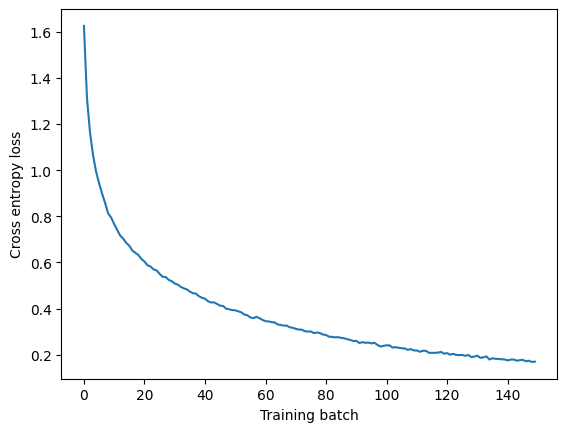

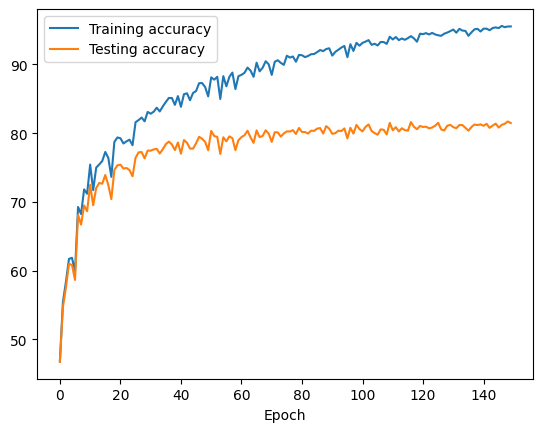

In [6]:

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = [] # Stores the loss for each training batch
train_accs = [] # Stores the training accuracy after each epoch
test_accs = [] # Stores the testing accuracy after each epoch

num_epochs = 150
for epoch in range(num_epochs):
    total_loss=0
    correct_cnt=0
    
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')
    start_time = time.perf_counter()
    model.train()
    
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        predict = model(X)
        l = criterion(predict, y)
        l.backward()
        optimizer.step()
        total_loss += l.item() * X.shape[0]
        
    losses.append(round(total_loss / len(train_dataset), 4))
    
    with torch.no_grad(): # Computing performance metrics does not require gradients
        model.eval()
        train_accs.append(evaluate_metric(model, train_loader, correct))
        test_accs.append(evaluate_metric(model, test_loader, correct)) #compute accuracy in the testing dataset

        end_time = time.perf_counter()
        print(f'Training accuracy: {train_accs[-1]:.2f}%. Testing accuracy: {test_accs[-1]:.2f}%. Duration: {end_time - start_time:.3f}s.') # Computes and displays training/testing dataset accuracy.


plt.plot(losses) # Plots the loss for each training batch
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()


plt.plot(train_accs, label='Training accuracy')
plt.plot(test_accs, label='Testing accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()